# Read Dataset

In [1]:
socar_df = pd.read_csv('insurance_fraud_detect_data.csv')

socar = socar_df.copy()
socar.drop(columns=['test_set','total_prsn_cnt'], inplace=True)
socar.tail()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,...,accident_hour,repair_cost,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN
15995,0,2,0,2,0,2,0,100,2,0,...,1,0.0000,0,1,1,0,1,0,0,0
15996,0,2,0,2,1,4,0,100,1,1,...,6,618439.4418,0,2,1,0,1,0,0,0
15997,0,2,1,2,0,4,0,100,1,0,...,5,0.0000,0,0,0,0,1,0,0,0
15998,0,2,0,2,0,2,0,100,2,0,...,2,0.0000,0,4,1,0,1,0,0,0
15999,0,2,0,2,0,1,0,100,1,0,...,6,391560.2156,1188750,2,0,0,1,0,0,0


# EDA

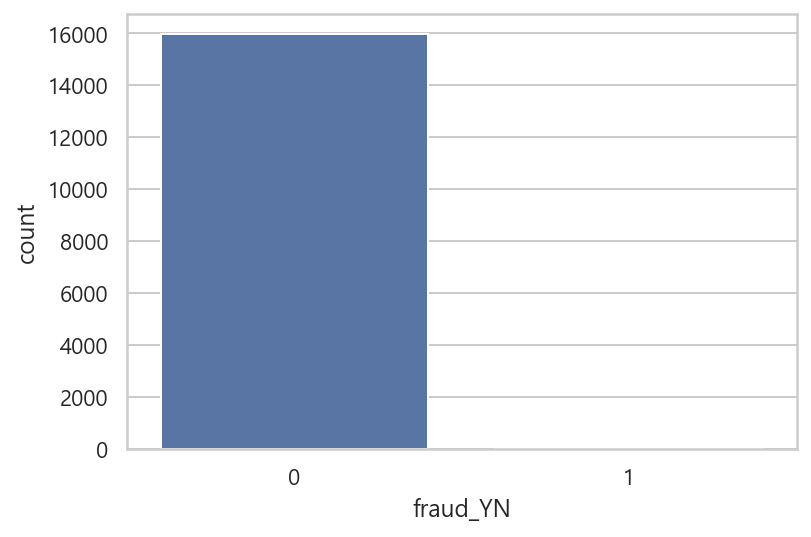

In [2]:
# Imbalanced Dataset
sns.countplot(data=socar, x='fraud_YN');

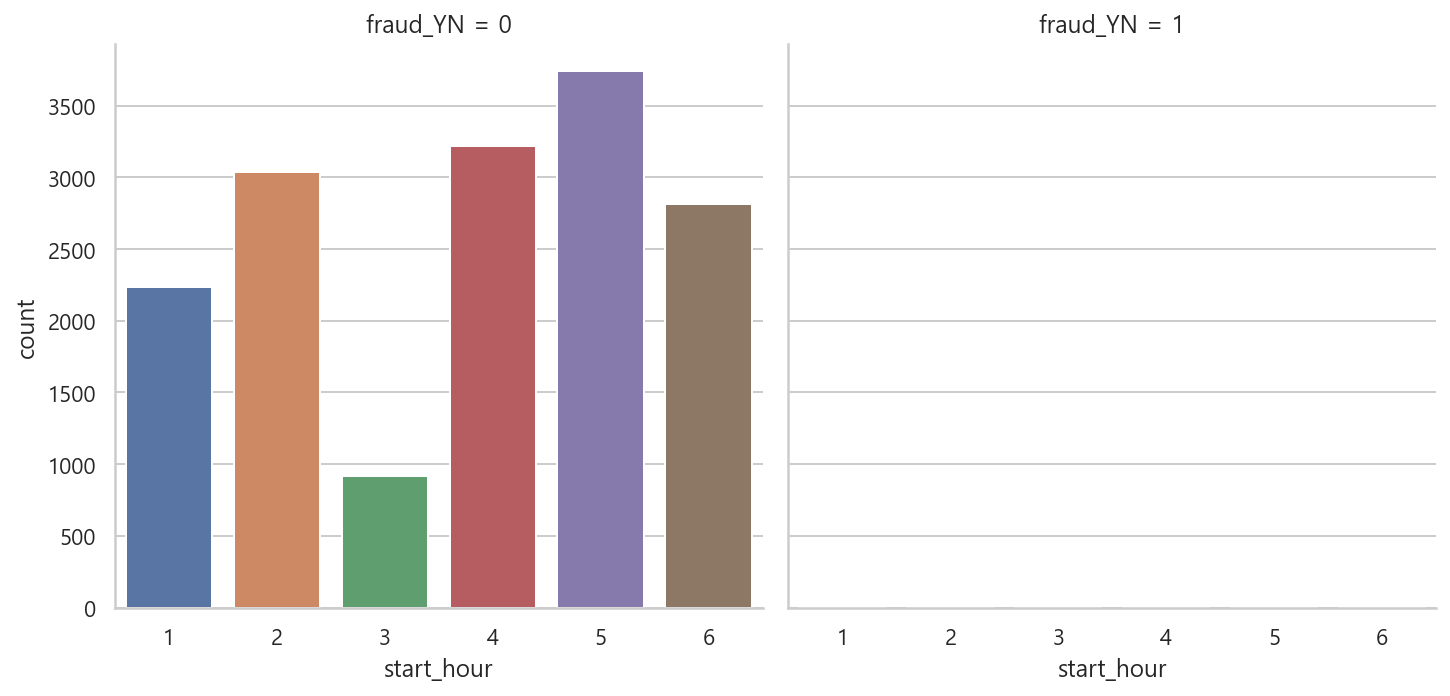

In [3]:
sns.catplot(data=socar, x='start_hour', col='fraud_YN', kind="count");

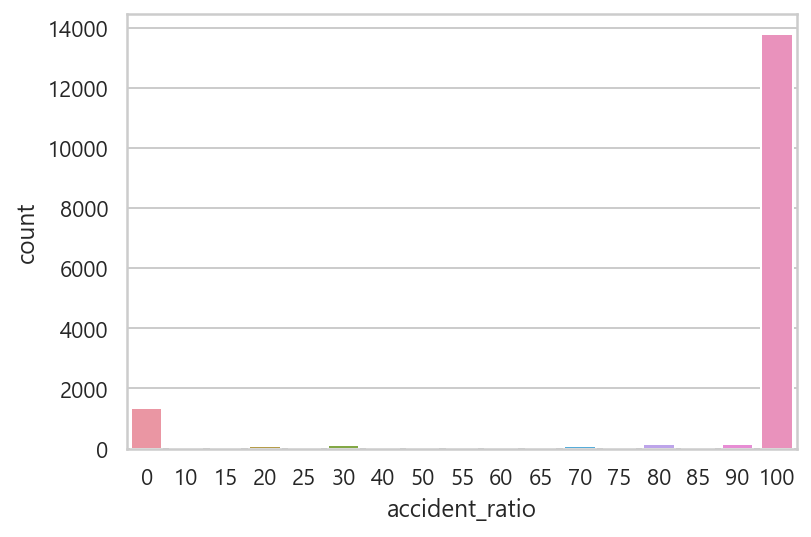

In [4]:
sns.countplot(data=socar, x='accident_ratio');

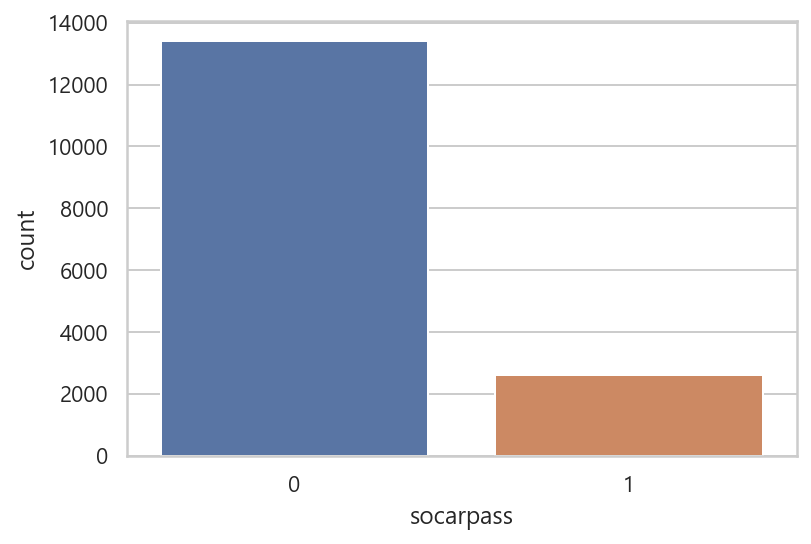

In [5]:
sns.countplot(data=socar, x='socarpass');

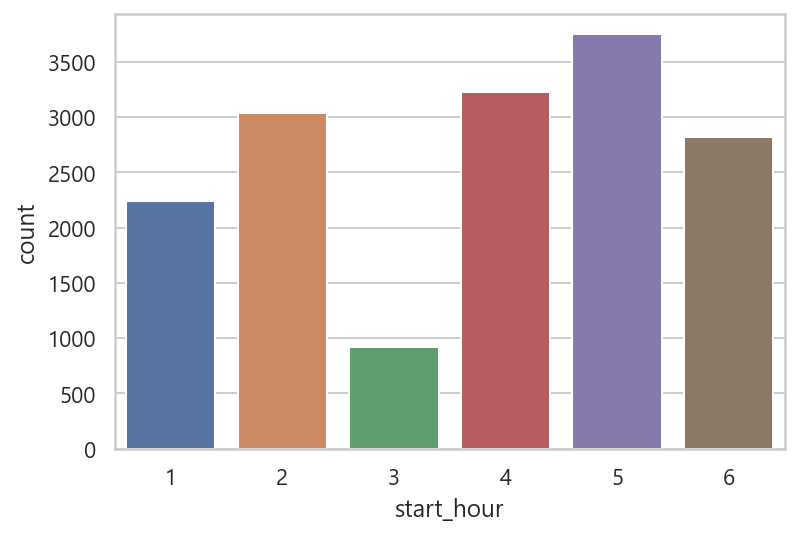

In [6]:
sns.countplot(data=socar, x='start_hour');

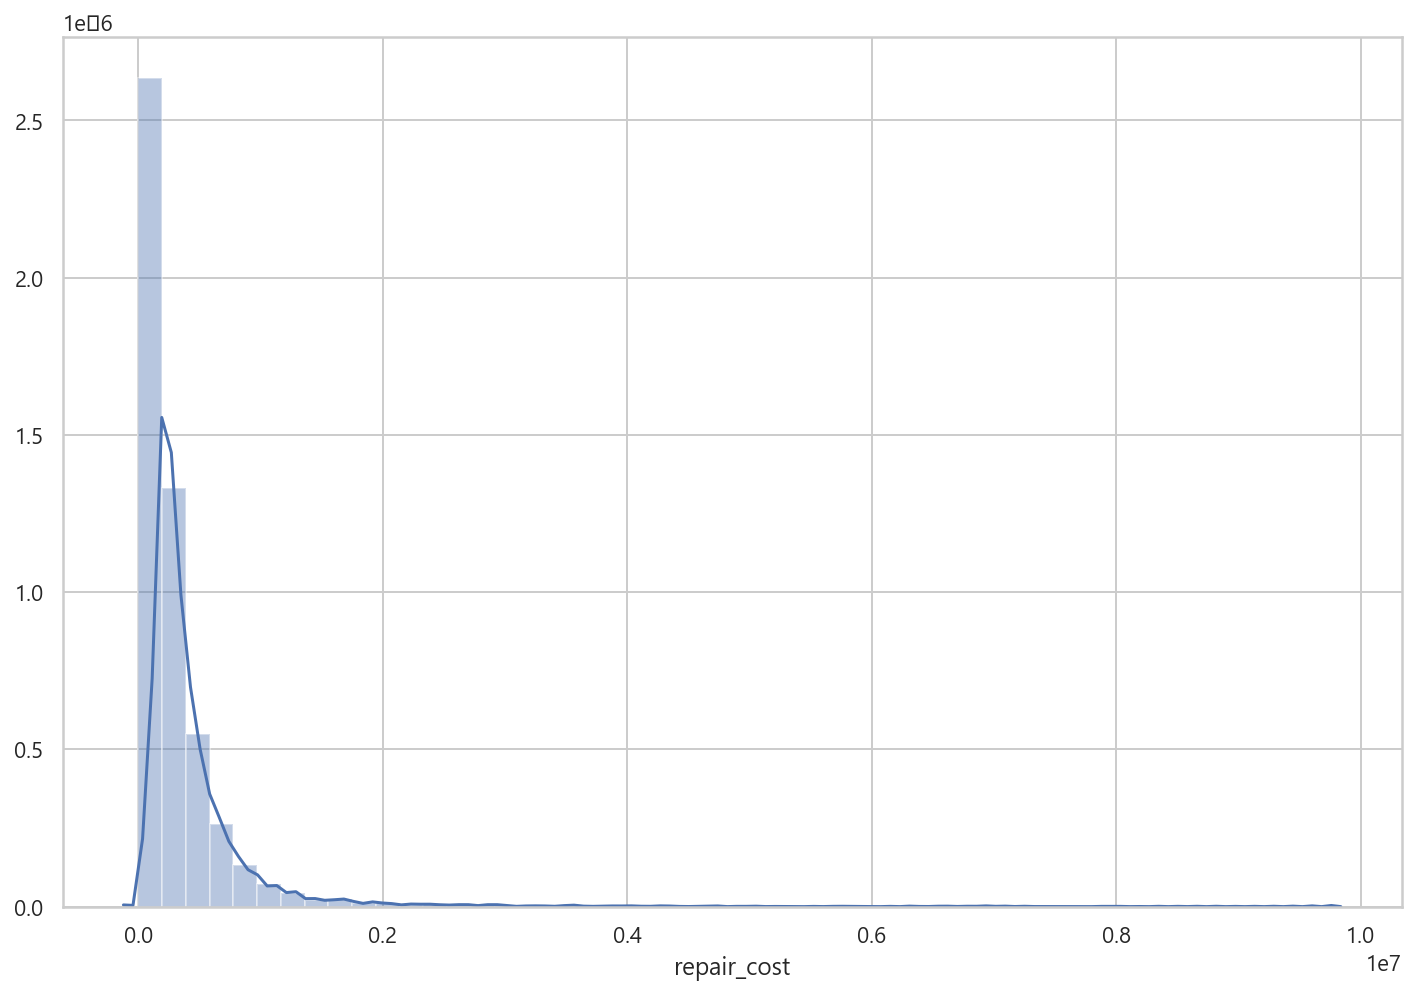

In [7]:
# Insure cost 0 means null
# Need to scale null and outlier datas.
plt.figure(figsize=(12,8))
sns.distplot(socar["repair_cost"])
plt.show()

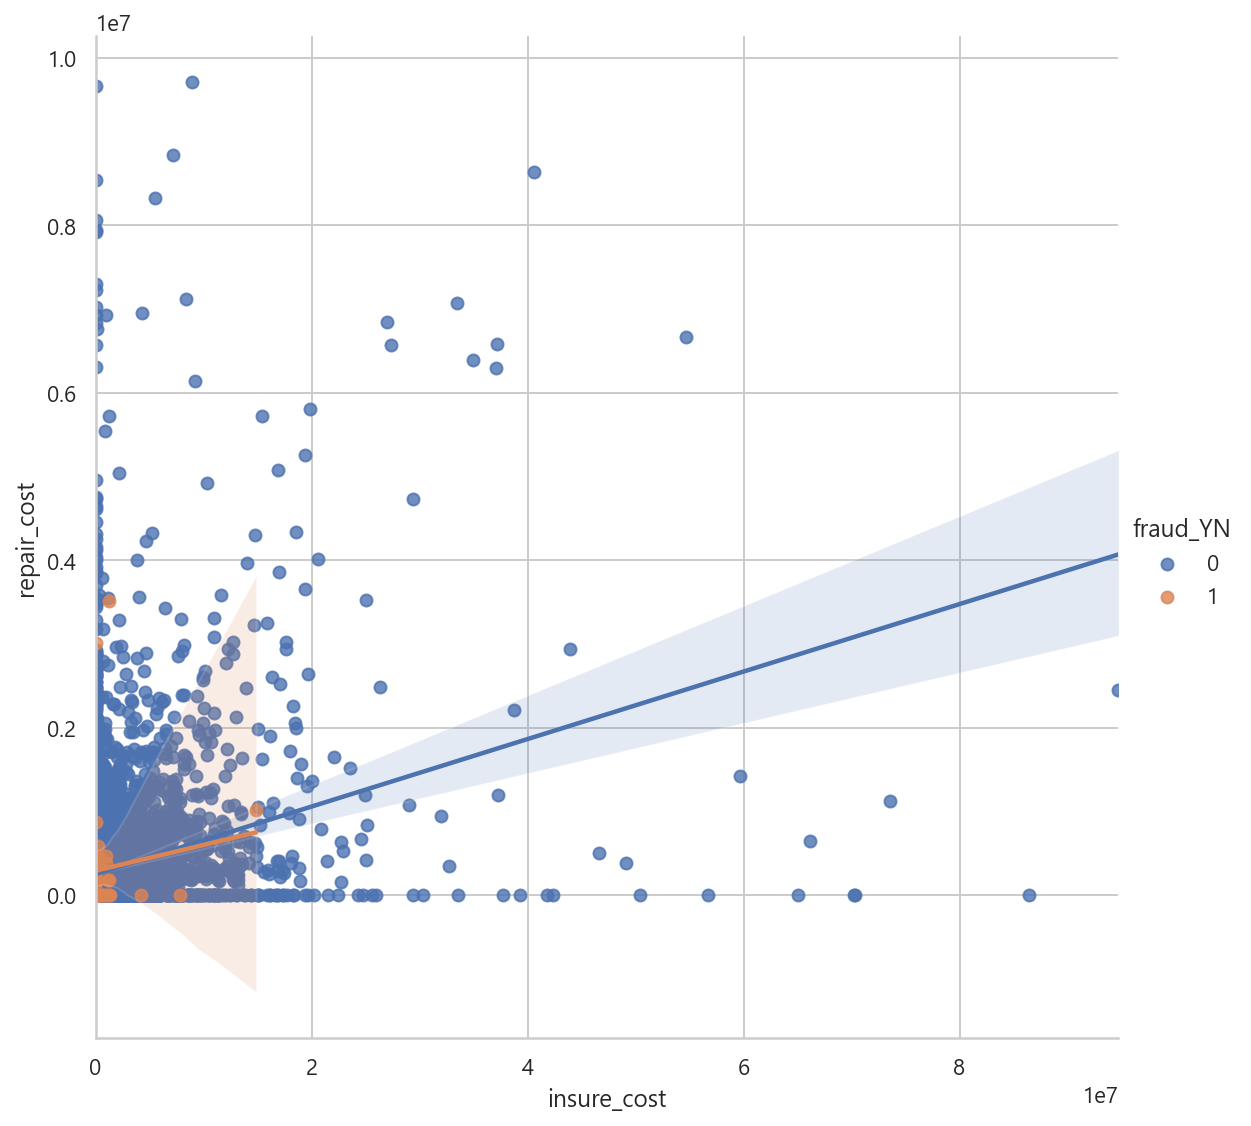

In [8]:
# Does insure cost and repair cnt affect repair cost?
sns.lmplot(data=socar, x='insure_cost', y='repair_cost', hue='fraud_YN', size=8);

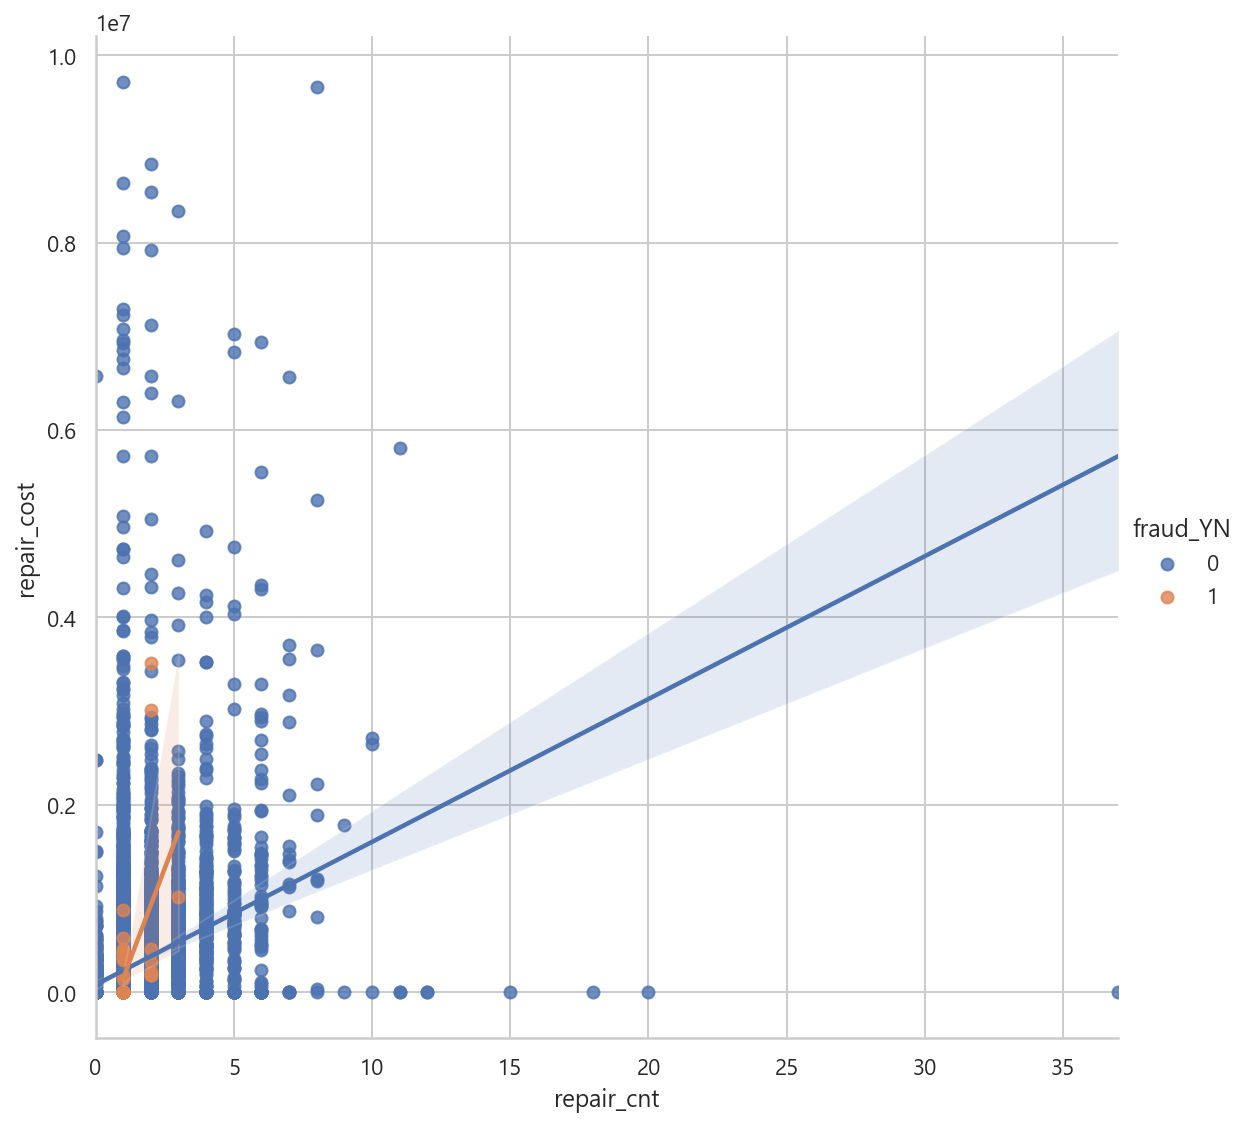

In [9]:
sns.lmplot(data=socar, x='repair_cnt', y='repair_cost', hue='fraud_YN', size=8);

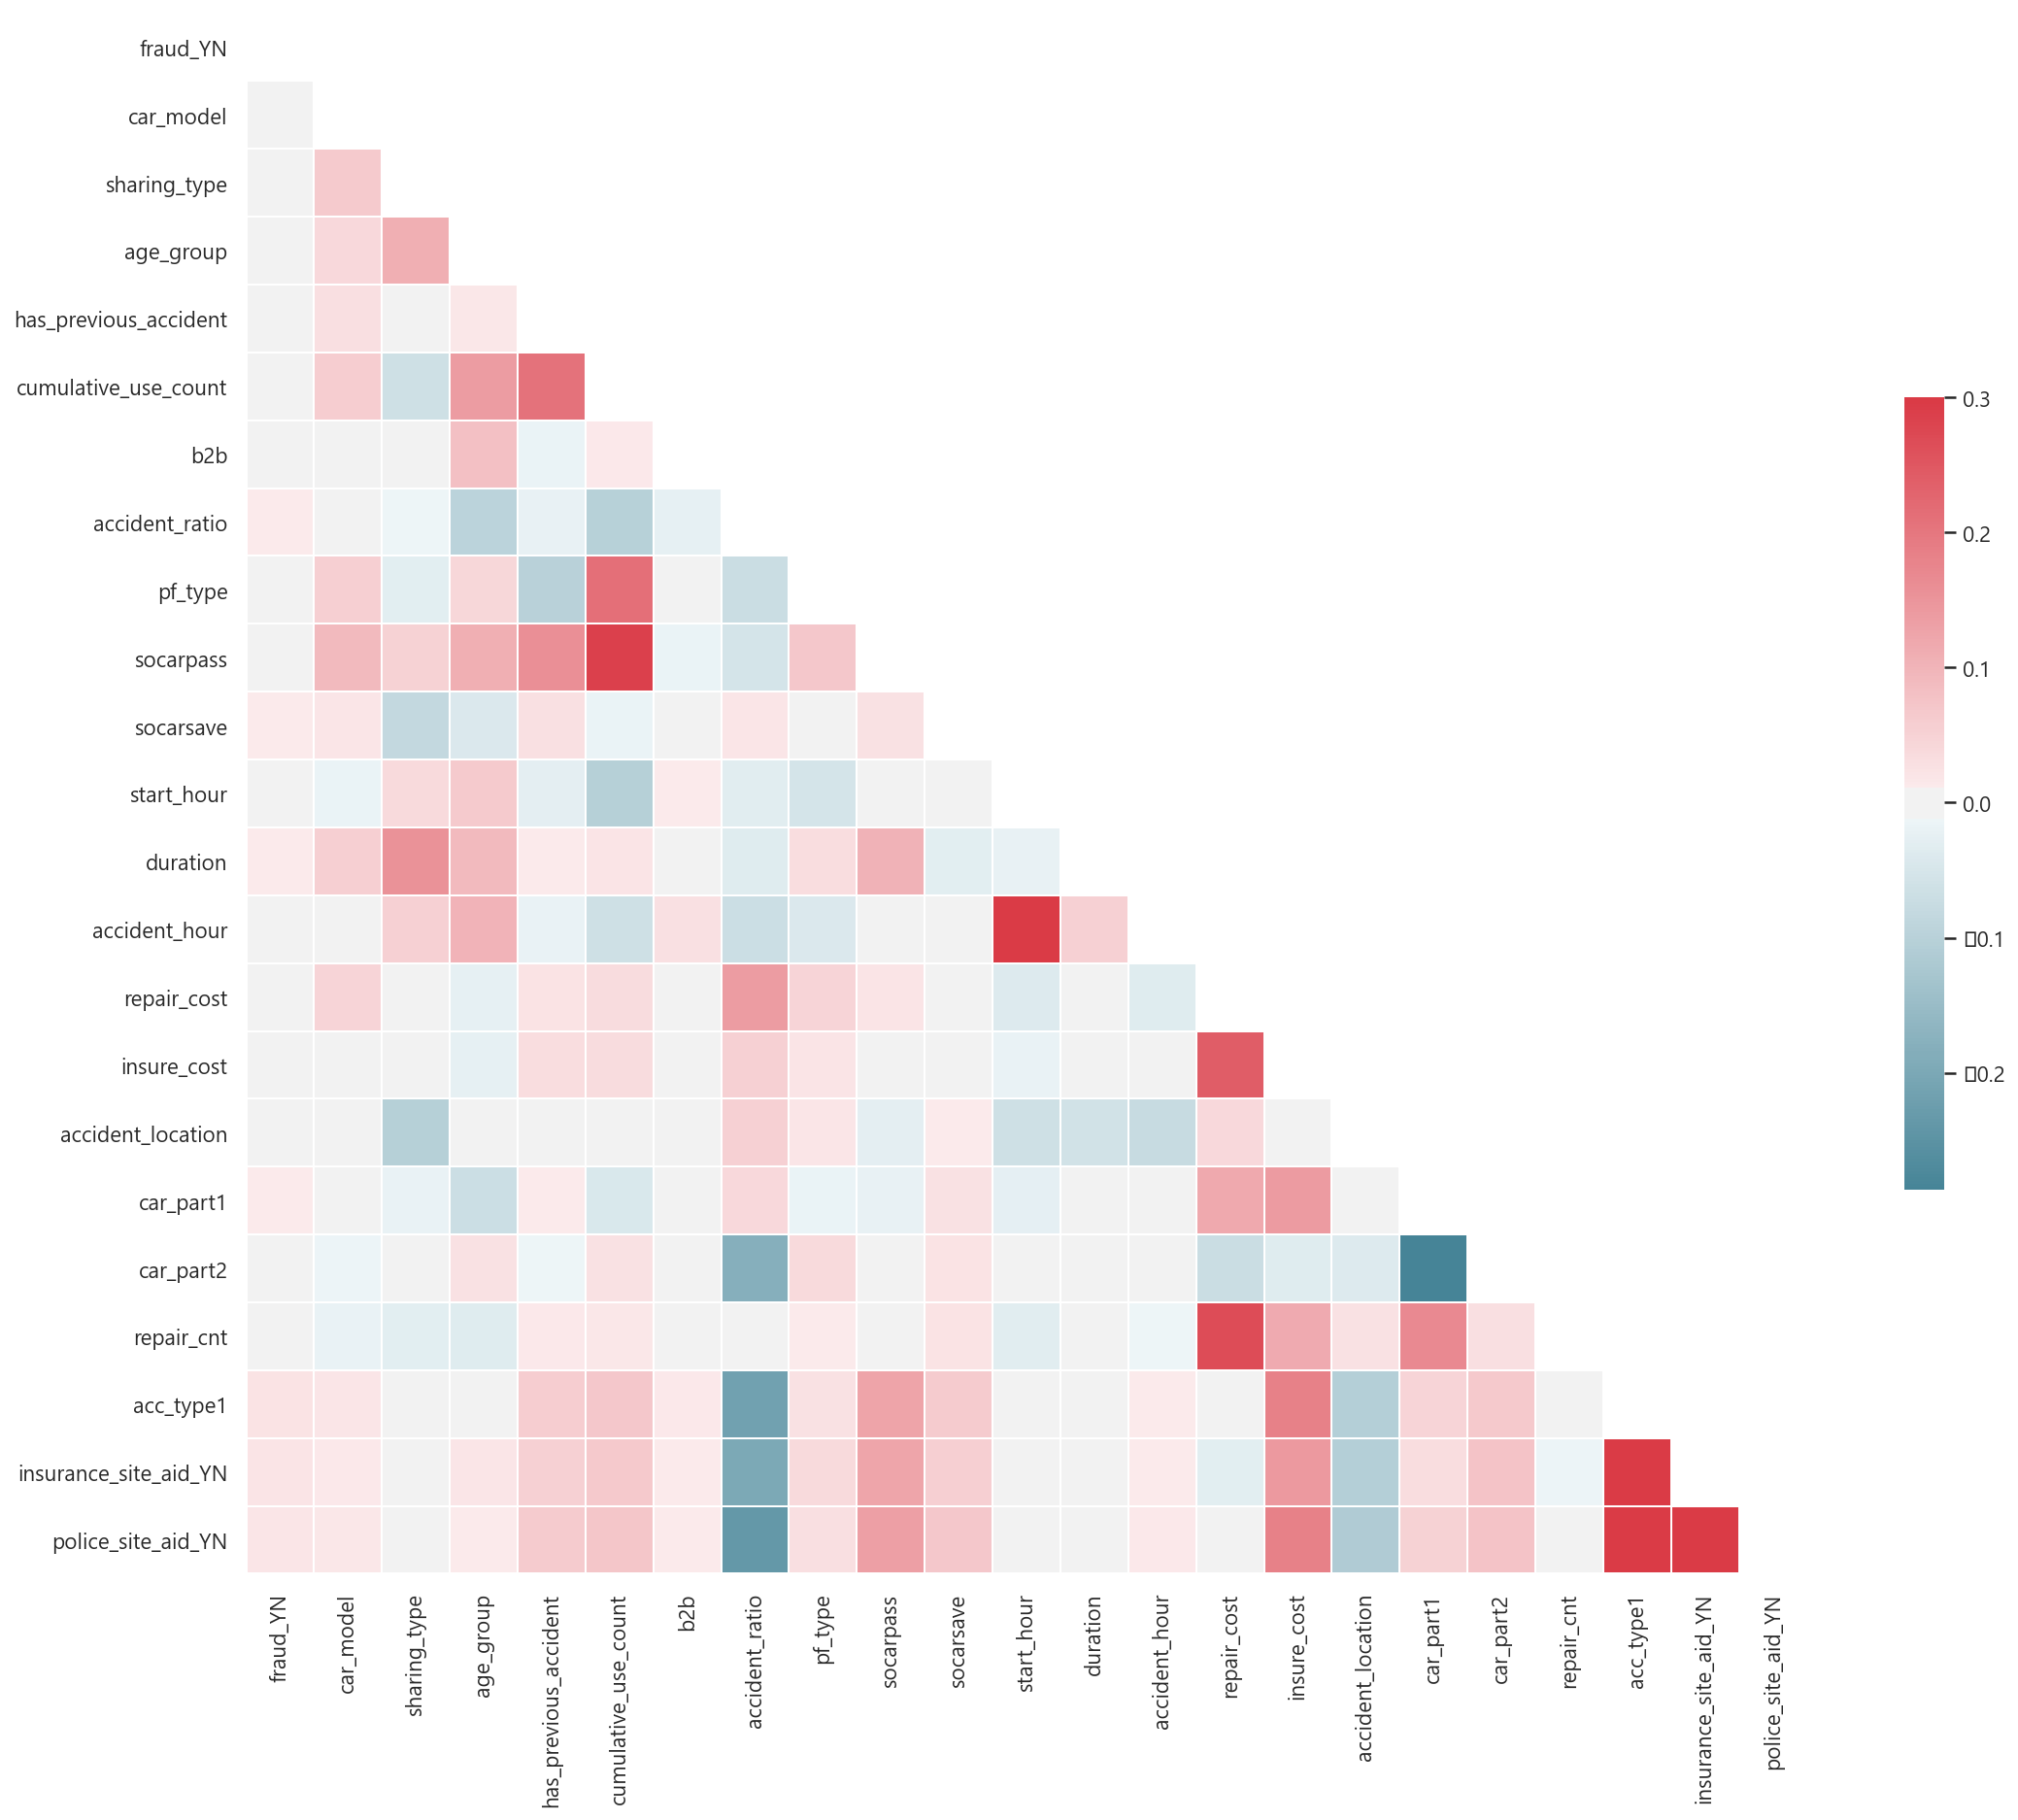

In [10]:
mask = np.zeros_like(socar.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(socar.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({"VIF Factor": [variance_inflation_factor(socar.values, idx) 
                             for idx in range(socar.shape[1])], "features": socar.columns})

,VIF Factor,features
0,1.004469,fraud_YN
1,5.629306,car_model
2,1.240358,sharing_type
3,5.577589,age_group
4,1.187860,has_previous_accident
5,6.568010,cumulative_use_count
6,1.015313,b2b
7,7.573733,accident_ratio
8,6.342331,pf_type
9,1.351580,socarpass


# Preprocessing

In [12]:
socar_pp = socar.copy()

In [13]:
repair_cost_mean = socar[(socar['repair_cost'] < 3000000) & (socar['repair_cost'] > 100000)]['repair_cost'].mean()
insure_cost_mean = socar[(socar['insure_cost'] < 3000000) & (socar['insure_cost'] > 100000)]['insure_cost'].mean()

socar_pp['repair_cost'][(socar['repair_cost'] >= 3000000)] = repair_cost_mean
socar_pp['repair_cost'][(socar['repair_cost'] <= 100000)] = repair_cost_mean

socar_pp['insure_cost'][(socar['insure_cost'] >= 3000000)] = insure_cost_mean
socar_pp['insure_cost'][(socar['insure_cost'] <= 100000)] = insure_cost_mean

# Scaling
- OneHotEncoder & MinMaxScaler

In [14]:
socar_1 = socar_pp.copy()

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
        'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN']

num_attribs = ['accident_ratio', 'repair_cost', 'insure_cost',]

full_pipeline = ColumnTransformer([('scaler', MinMaxScaler(), num_attribs),
              ('cat', OneHotEncoder(), cat_attribs),
             ])
socar_scaled = full_pipeline.fit_transform(socar_1)
socar_scaled.shape

(16000, 84)

# Split dataset

In [16]:
from sklearn.model_selection import train_test_split

X = socar_scaled
y = socar['fraud_YN'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

In [17]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([12767,    33], dtype=int64))

In [18]:
tmp_tr = np.unique(y_train, return_counts=True)[1]
tmp_test = np.unique(y_test, return_counts=True)[1]

print("ratio of y_train per x_train :", tmp_tr[1]/len(y_train) * 100)
print("ratio of y_test per x_test :", tmp_test[1]/len(y_test) * 100)

ratio of y_train per x_train : 0.2578125
ratio of y_test per x_test : 0.25


# Evaluation

In [19]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc


In [20]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    
    print('=> confusion matrix')
    print(confusion)
    print('===========')
    
    print('Accuracy : {0:.4f}, Precision:{1:.4f}'.format(acc, pre))
    print('Recall : {0:.4f}, F1:{1:.4f}, AUC:{2:.4f}'.format(re, f1, auc))
    

In [21]:
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression(random_state=10)
lg_clf.fit(X_train, y_train)
lg_pred = lg_clf.predict(X_test)

print_clf_eval(y_test, lg_pred)

=> confusion matrix
[[3192    0]
 [   8    0]]
Accuracy : 0.9975, Precision:0.0000
Recall : 0.0000, F1:0.0000, AUC:0.5000


In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=10, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

=> confusion matrix
[[3192    0]
 [   8    0]]
Accuracy : 0.9975, Precision:0.0000
Recall : 0.0000, F1:0.0000, AUC:0.5000


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=10, n_jobs=-1, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

=> confusion matrix
[[3192    0]
 [   8    0]]
Accuracy : 0.9975, Precision:0.0000
Recall : 0.0000, F1:0.0000, AUC:0.5000


In [24]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

=> confusion matrix
[[3192    0]
 [   8    0]]
Accuracy : 0.9975, Precision:0.0000
Recall : 0.0000, F1:0.0000, AUC:0.5000


# Over Sampling

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=10)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [26]:
X_train.shape, y_train.shape, X_train_over.shape, y_train_over.shape

((12800, 84), (12800,), (25534, 84), (25534,))

In [27]:
np.unique(y_train, return_counts=True), np.unique(y_train_over, return_counts=True)

((array([0, 1], dtype=int64), array([12767,    33], dtype=int64)),
 (array([0, 1], dtype=int64), array([12767, 12767], dtype=int64)))

In [28]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy','precision','recall','f1','roc_auc']
    tmp = []
    
    for model in models:

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        tmp.append(get_clf_eval(y_test, pred))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)


In [29]:
models = [dt_clf, rf_clf, lgbm_clf]
model_names = ['DecisionTree', 'RandomForest','LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print('Fit time : ', time.time() - start_time)
results

Fit time :  3.4442830085754395


,accuracy,precision,recall,f1,roc_auc
DecisionTree,0.9075,0.0,0.0,0.0,0.454887
RandomForest,0.9975,0.0,0.0,0.0,0.500000
LightGBM,0.9975,0.0,0.0,0.0,0.500000


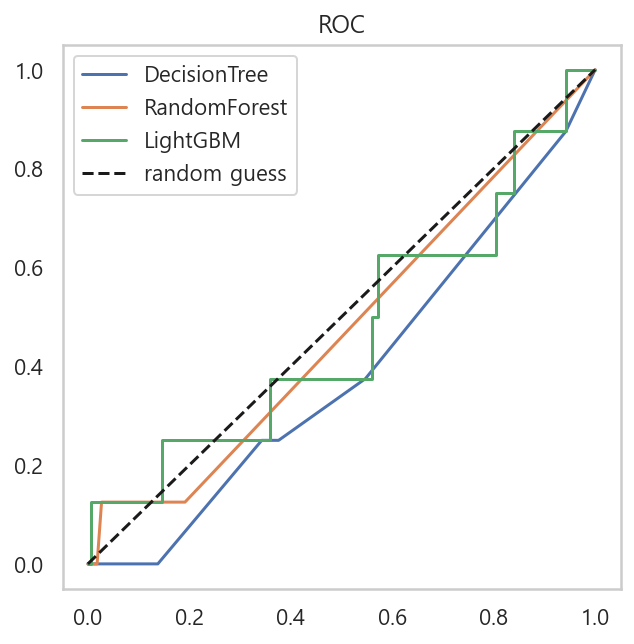

In [30]:
from sklearn.metrics import roc_curve

def draw_roc_curve(models, model_names, X_valid, y_valid):
    plt.figure(figsize=(5, 5))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, pred)
        plt.plot(fpr, tpr, label=model_names[model])
        
    plt.plot([0, 1], [0, 1], "k--", label="random guess")
    plt.title("ROC")
    plt.legend()
    plt.grid()
    plt.show()
    
draw_roc_curve(models, model_names, X_test, y_test)

# Hyper Parameter Tuning
- All recall score is 0

In [31]:
# from sklearn.model_selection import GridSearchCV

# params = {'max_depth' : [2,4,6,8]}
# socar_tree = DecisionTreeClassifier(max_depth=2, random_state=10)

# gridsearch = GridSearchCV(estimator=socar_tree, param_grid=params, cv=5, scoring='recall')
# gridsearch.fit(X, y)
# gridsearch.best_estimator_

In [32]:
# params = {'n_estimators' : [50, 100, 150, 200]}
# socar_random = RandomForestClassifier(random_state=10, n_jobs=-1, n_estimators=100)

# gridsearch = GridSearchCV(estimator=socar_random, param_grid=params, cv=5, scoring='recall')
# gridsearch.fit(X, y)
# gridsearch.best_estimator_

In [33]:
# params = {'n_estimators' : [400, 700, 1000], 'num_leaves' : [16, 32, 64]}
# socar_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

# gridsearch = GridSearchCV(estimator=socar_lgbm, param_grid=params, cv=5, scoring='recall')
# gridsearch.fit(X, y)
# gridsearch.best_estimator_

# Function

Fit time :  0.5360550880432129


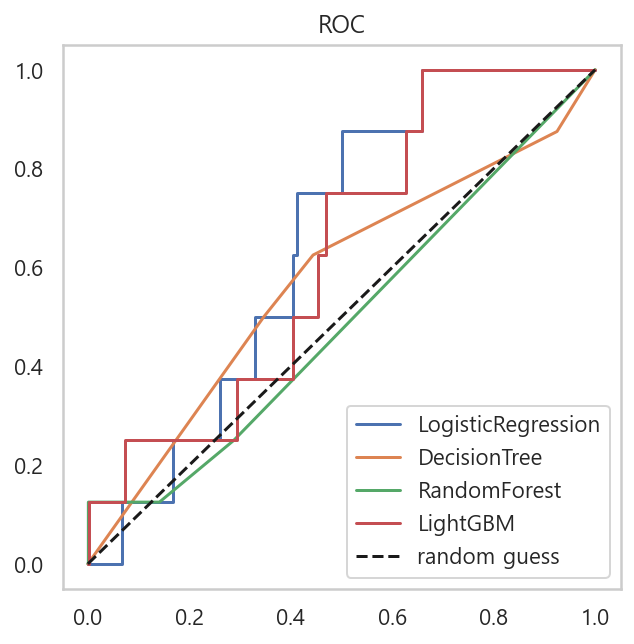

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.749062,0.002503,0.250,0.004957,0.500157
DecisionTree,0.556250,0.003516,0.625,0.006993,0.590539
RandomForest,0.996875,0.250000,0.125,0.166667,0.562030
LightGBM,0.886875,0.005587,0.250,0.010929,0.569236


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


def model_scores(data, scaler, drop_cols=None, oversampling=True, random_state=10):
    X = data.drop(['fraud_YN'], axis=1)
    y = data['fraud_YN']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    
    scaler_obj = scaler
    scaler_obj.fit(X_train[['accident_ratio','repair_cost','insure_cost']])

    X_train[['accident_ratio','repair_cost','insure_cost']] = scaler_obj.transform(X_train[['accident_ratio','repair_cost','insure_cost']])
    X_test[['accident_ratio','repair_cost','insure_cost']] = scaler_obj.transform(X_test[['accident_ratio','repair_cost','insure_cost']])
    
    if drop_cols:
        X_train.drop(drop_cols, axis=1, inplace=True)
        X_test.drop(drop_cols, axis=1, inplace=True)
    
    if oversampling:
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_sample(X_train, y_train)
    
    lg_clf = LogisticRegression(random_state=random_state)
    dt_clf = DecisionTreeClassifier(random_state=random_state, max_depth=2)
    rf_clf = RandomForestClassifier(random_state=random_state, n_jobs=-1, n_estimators=50)
    lgbm_clf = LGBMClassifier(random_state=random_state, num_leaves=4, n_jobs=-1, boost_from_average=False)
    
    models = [lg_clf, dt_clf, rf_clf, lgbm_clf]
    model_names = ['LogisticRegression','DecisionTree', 'RandomForest','LightGBM']

#     params = {'n_estimators' : [600, 200, 400], 'num_leaves' : [4, 8, 16]}

#     gridsearch = GridSearchCV(estimator=lgbm_clf, param_grid=params, cv=5, scoring='recall')
#     gridsearch.fit(X_train, y_train)
#     print(gridsearch.best_estimator_)
    
    start_time = time.time()
    results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

    print('Fit time : ', time.time() - start_time)
    
    draw_roc_curve(models, model_names, X_test, y_test)
    
    return results

model_scores(socar_1, StandardScaler())

# 2nd Trial
- MinMaxScaler Only
- Hyper Parameter Tuning

In [35]:
socar_2 = socar_pp.copy()

Fit time :  0.5611116886138916


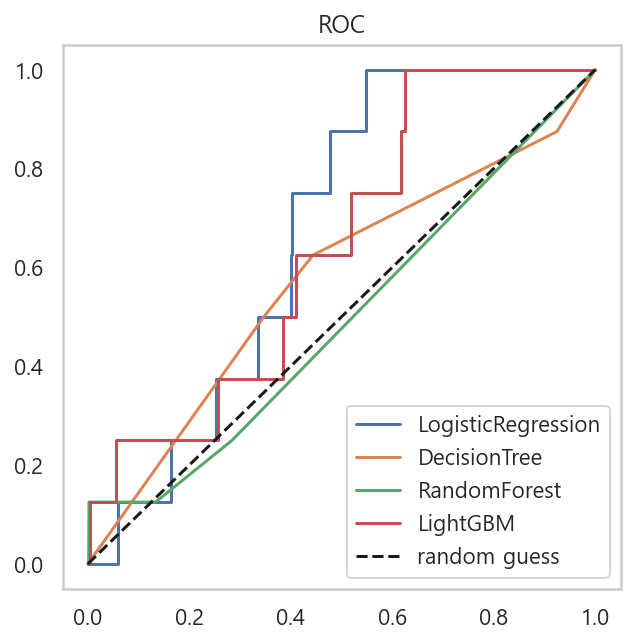

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.752188,0.002535,0.250,0.005019,0.501723
DecisionTree,0.556250,0.003516,0.625,0.006993,0.590539
RandomForest,0.996875,0.000000,0.000,0.000000,0.499687
LightGBM,0.886875,0.005587,0.250,0.010929,0.569236


In [36]:
model_scores(socar_2, MinMaxScaler())

# 3rd Trial
- Drop where repair_cnt is 0(null)
- StandardScaler Only

In [37]:
socar_3 = socar_pp.copy()

In [38]:
((socar['fraud_YN'] == 0) & (socar['repair_cnt'] == 0)).sum(), ((socar['fraud_YN'] == 1) & (socar['repair_cnt'] == 0)).sum()

(271, 0)

In [39]:
socar_3.drop(socar[socar['repair_cnt'] == 0].index, inplace=True)

Fit time :  0.5316894054412842


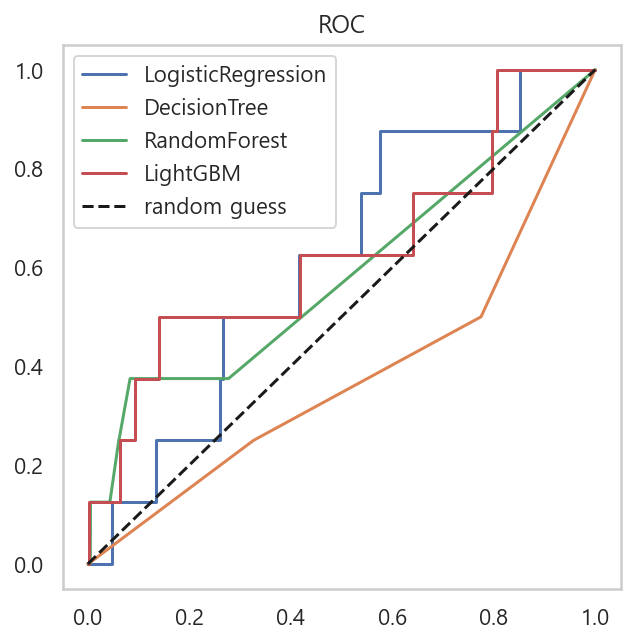

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.754927,0.002608,0.250,0.005161,0.503107
DecisionTree,0.672282,0.001947,0.250,0.003865,0.461679
RandomForest,0.995550,0.000000,0.000,0.000000,0.499044
LightGBM,0.878258,0.007874,0.375,0.015424,0.627271


In [40]:
model_scores(socar_3, StandardScaler())

# 4th Trial
- Preprocessing null to median
- Drop where repair_cnt is 0(null)
- StandardScaler Only

In [41]:
socar_4 = socar.copy()

In [42]:
repair_cost_median = socar[(socar['repair_cost'] != 0)]['repair_cost'].median()
socar_4['repair_cost'][(socar_4['repair_cost'] == 0)] = repair_cost_median

insure_cost_median = socar[(socar['insure_cost'] != 0)]['insure_cost'].median()
socar_4['insure_cost'][(socar_4['insure_cost'] == 0)] = insure_cost_median

In [43]:
socar_4.drop(socar[socar['repair_cnt'] == 0].index, inplace=True)

Fit time :  0.5261030197143555


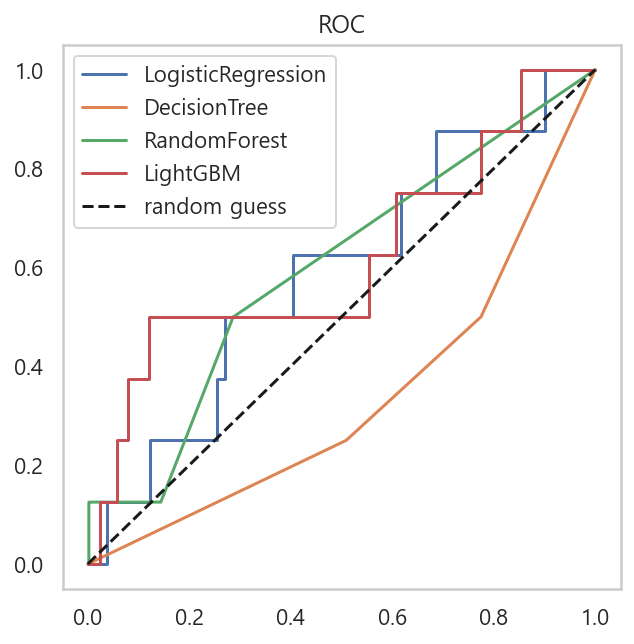

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.757152,0.002632,0.250,0.005208,0.504222
DecisionTree,0.490146,0.001250,0.250,0.002488,0.370379
RandomForest,0.995868,0.142857,0.125,0.133333,0.561544
LightGBM,0.876033,0.010256,0.500,0.020101,0.688496


In [44]:
model_scores(socar_4, StandardScaler())

# 5th Trial
- Drop insure_cost & repair_cost
- Drop where repair_cnt is 0(null)
- Preprocessing null to median
- MaxAbsScaler Only

In [45]:
socar_5 = socar.copy()

In [46]:
repair_cost_median = socar[(socar['repair_cost'] != 0)]['repair_cost'].median()
socar_5['repair_cost'][(socar_5['repair_cost'] == 0)] = repair_cost_median

insure_cost_median = socar[(socar['insure_cost'] != 0)]['insure_cost'].median()
socar_5['insure_cost'][(socar_5['insure_cost'] == 0)] = insure_cost_median

In [47]:
socar_5.drop(socar[socar['repair_cnt'] == 0].index, inplace=True)

Fit time :  0.49910902976989746


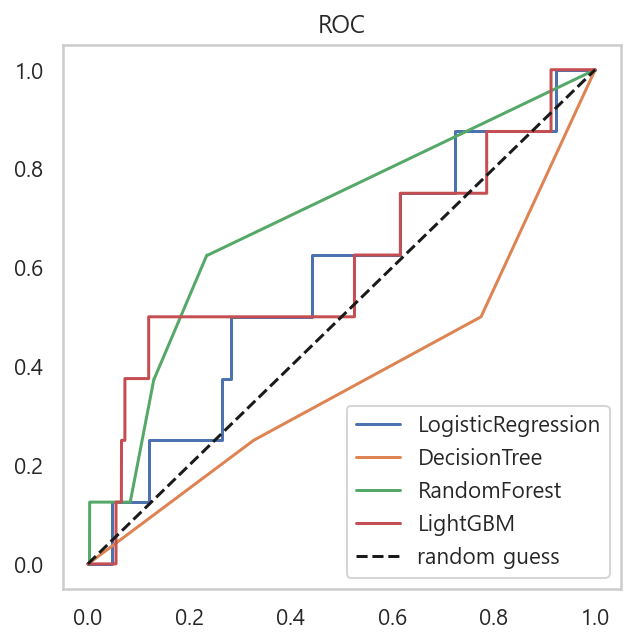

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.741577,0.002472,0.25,0.004896,0.496415
DecisionTree,0.672282,0.001947,0.25,0.003865,0.461679
RandomForest,0.994596,0.000000,0.00,0.000000,0.498566
LightGBM,0.835029,0.007707,0.50,0.015180,0.667941


In [48]:
model_scores(socar_5, MaxAbsScaler(), drop_cols=['repair_cost','insure_cost'])

# 6th Trial
- drop police_site_aid_YN & acc_type1
- drop where repair_cnt is 0(null)
- MinMaxScaler Only

In [49]:
socar_6 = socar.copy()

In [50]:
socar_6.drop(socar[socar['repair_cnt'] == 0].index, inplace=True)

Fit time :  0.5211026668548584


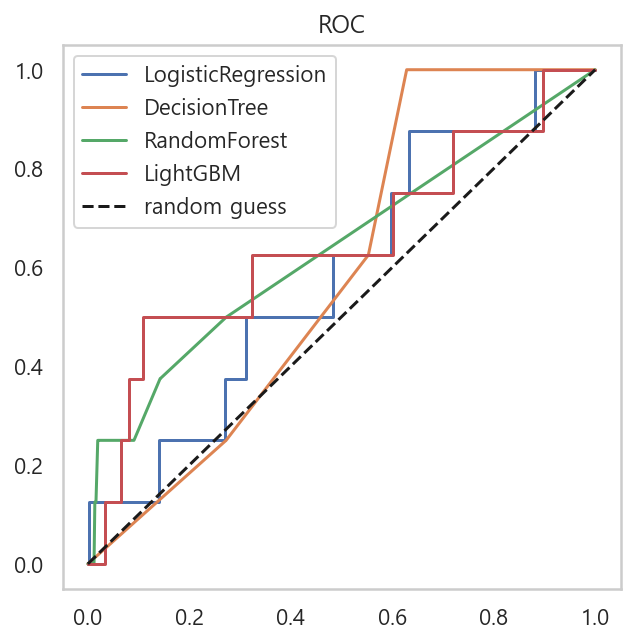

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.753655,0.002594,0.25,0.005135,0.502470
DecisionTree,0.726319,0.002334,0.25,0.004624,0.488767
RandomForest,0.995868,0.000000,0.00,0.000000,0.499203
LightGBM,0.883344,0.010899,0.50,0.021333,0.692161


In [51]:
model_scores(socar_6, MinMaxScaler(), drop_cols=['police_site_aid_YN', 'acc_type1'])